In [3]:
"""
run_bayesian.py
Python script to run Bayesian analysis for DIUSST model
"""

# Change working directory to curr
import os

# Load external modules
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import emcee
import corner
from multiprocessing import Pool
from multiprocessing import cpu_count

# Load custom functions
from interpolation import cfl_interpolation
from diusst_model import diusst_bayesian as diusst

# Time stamp
from datetime import datetime
now = datetime.now()
timestamp = now.strftime("%y%m%d-%H%M%S")

In [4]:
###########################################################
# RUN SETTINGS (check before each run)

# Output storage
output_path = '../output/'
run_id = '_blabla'

# Fit parameters
param_names = ['kappa', 'mu', 'attenu']

# Parameter limits
param_min = np.array([0, 0, 0])
param_max = np.array([7e-4, 1, 10])

# Initial walker positions
param_start = np.array([2e-4, 1e-4, 2.5])

# Sampling
nwalkers = 8
nsteps = 700
burninsteps = 50

# DIUSST model
scheme = 'euler'
dz0 = 0.05
ngrid = 80
diffu = 1
opac = 1
k_mol = 1e-7
maxwind = 10

# Dataset
data_path = '../data/bayesian_training/'
data_filename = 'training_minnett_ssterr03-10_humid10.csv'
data_interval = [786,1377]

# Other settings
parallel = True

###########################################################
# (End of run settings)
###########################################################

In [5]:
# Load dataset
data_orig = pd.read_csv(data_path+data_filename)[data_interval[0]:data_interval[1]]

# interpolate to meet CFL condition
data, dtlist = cfl_interpolation(data_orig, dz0=dz0, ngrid=ngrid,
        a=0, b=1, k_eddy_max=param_max[0], maxwind=maxwind)

+++ Variable time-step interpolation +++
Interpolated dataset has 307532 time steps with average length 4.092 s.
Constant dt interpolation would require dt = 0.284 s --> 1682702 steps.
Computation time will be reduced by 81.724 %
++++++++++++++++++++++++++++++++++++++++


In [6]:
data_orig

,times,sst,sst_err,ftemp,wind,atemp,swrad,humid
786,691337.04,303.137,1.0,303.484,1.492,302.197,0.5,0.01
787,692022.96,303.126,1.0,303.508,1.029,302.257,0.5,0.01
788,692717.04,303.142,1.0,303.498,0.709,302.219,0.5,0.01
789,693402.72,303.127,1.0,303.509,0.434,302.162,0.5,0.01
790,694097.04,303.132,1.0,303.456,0.682,302.225,0.7,0.01
...,...,...,...,...,...,...,...,...
1372,1119935.04,299.239,1.0,297.522,5.100,299.192,0.8,0.01
1373,1120634.64,299.456,1.0,299.688,5.360,299.461,1.0,0.01
1374,1121343.12,299.515,1.0,299.059,5.302,299.187,1.3,0.01
1375,1122042.84,298.786,1.0,298.827,5.738,299.145,0.7,0.01


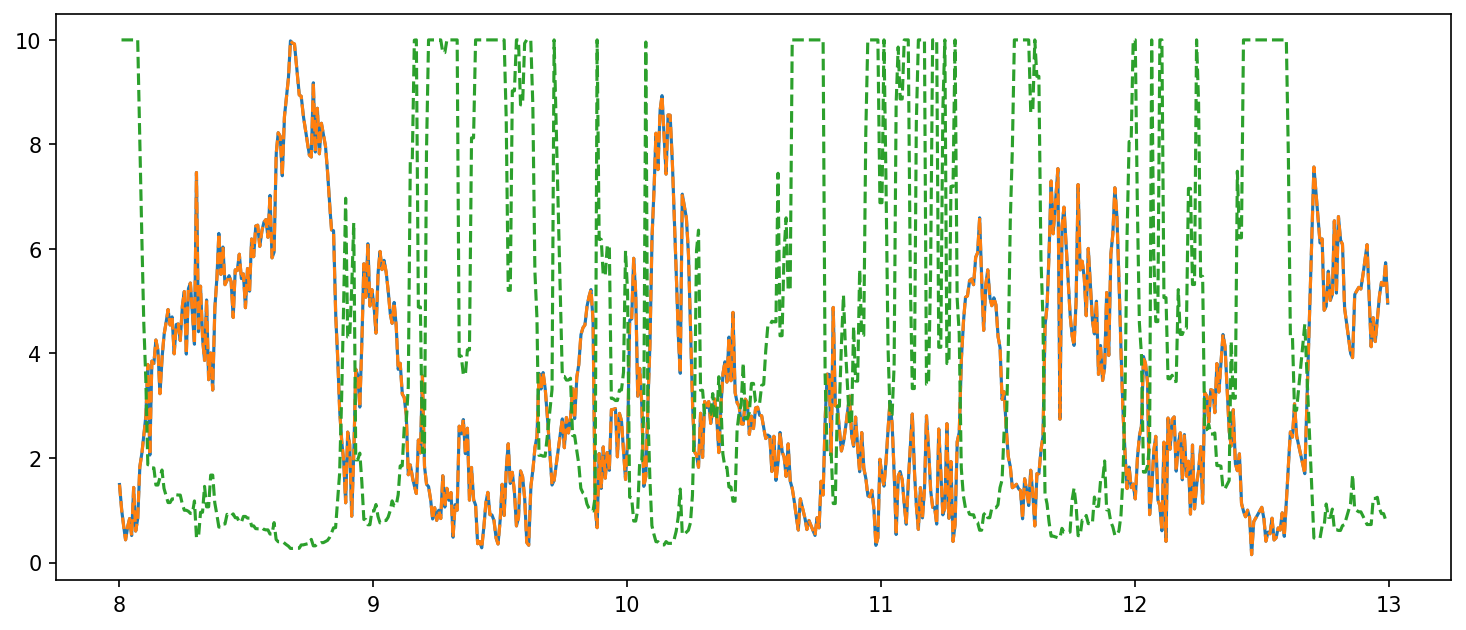

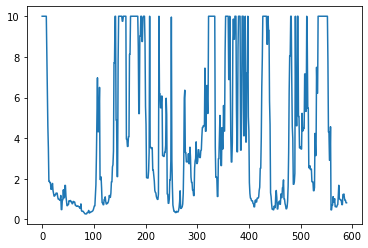

In [7]:
fig, ax = plt.subplots(dpi=150,figsize=(12,5))
ax.plot(data['times']/86400,data['wind'])
ax.plot(data_orig['times']/86400,data_orig['wind'],'--')
ax.plot(data_orig['times'][1:]/86400,dtlist,'--')
plt.show()

fig, ax = plt.subplots()
ax.plot(dtlist)

In [ ]:
# Define posterior distribution function
def log_prob(x):
    if (x<param_min).any() or (x>param_max).any():
        return -np.inf
    else:
        mse = bayesian_likelihood(x)
        return - mse

# initialize emcee
ndim = len(param_names)
initial = np.zeros((nwalkers, ndim))
for i in range(nwalkers):
    initial[i] = param_start

# prerequisites for parallelization
os.environ["OMP_NUM_THREADS"] = "1"
ncpu = cpu_count()
print("{0} CPUs".format(ncpu))

# run MCMC sampler
if parallel:
    with Pool() as pool:
        sampler = emcee.EnsembleSampler(nwalkers, ndim, log_prob, pool=pool)
        burnin = sampler.run_mcmc(initial, burninsteps, progress=True)
        sampler.reset()
        mcrun = sampler.run_mcmc(burnin, nsteps, progress=True)

else:
    sampler = emcee.EnsembleSampler(nwalkers, ndim, log_prob)
    burnin = sampler.run_mcmc(initial, burninsteps, progress=True)
    sampler.reset()
    mcrun = sampler.run_mcmc(burnin, nsteps, progress=True)

# Get sampling results
samples = sampler.get_chain()
autocorrtime = sampler.get_autocorr_time()
probs = sampler.get_log_prob()

samples_df = pd.DataFrame(samples)
autocorrtime_df = pd.DataFrame(autocorrtime)
probs_df = pd.DataFrame(probs)

samples_df.to_csv(data_path+timestamp+run_id+'samples.csv')
autocorrtime_df.to_csv(data_path+timestamp+run_id+'autocorrtime.csv')
probs_df.to_csv(data_path+timestamp+run_id+'probs.csv')

In [40]:
kappa, mu, attenu = param_start
import time
simstart = time.time()

ftemp = np.mean(data['ftemp'].to_numpy(np.float64))
sst_data = data['sst'].to_numpy(np.float64) - data['ftemp'].to_numpy(np.float64)
sst_err = data['sst_err'].to_numpy(np.float64)

times = data['times'].to_numpy(np.float64)
wind = data['wind'].to_numpy(np.float64)
atemp = data['atemp'].to_numpy(np.float64)
swrad = data['swrad'].to_numpy(np.float64)
humid = data['humid'].to_numpy(np.float64)

print((time.time()-simstart)*10000)

93.44339370727539


In [33]:
simu = diusst(
            times, atemp, swrad, u_data=wind, sa_data=humid, T_f=ftemp,
            k_eddy=kappa, mu=mu, attenu=attenu,
            opac=opac, k_mol=k_mol,
            dz=dz0, ngrid=ngrid)

31.626843452453613


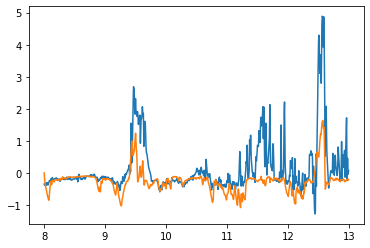

In [38]:
plt.plot(times/86400,sst_data)
plt.plot(times/86400,simu[0][:,0]-ftemp)

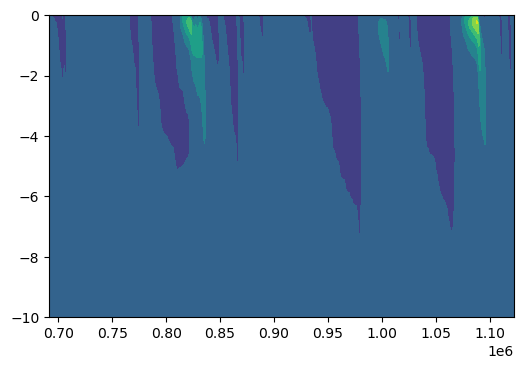

In [51]:
fig, ax = plt.subplots(dpi=100)
ax.contourf(times,simu[1],simu[0].transpose())